In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, )
from mlxtend.plotting import plot_confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../input/Churn_Modelling.csv")

In [3]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
dataset.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
dropped = ["RowNumber","CustomerId","Surname"]

for i in range(len(dropped)):
    del dataset[dropped[i]]

In [7]:
dataset["Balance"] = np.ceil(dataset["Balance"]).astype(int)
dataset["EstimatedSalary"] = np.ceil(dataset["EstimatedSalary"]).astype(int)

In [8]:
dataset = pd.get_dummies(dataset)

In [9]:
dataset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0,1,1,1,101349,1,1,0,0,1,0
1,608,41,1,83808,1,0,1,112543,0,0,0,1,1,0
2,502,42,8,159661,3,1,0,113932,1,1,0,0,1,0
3,699,39,1,0,2,0,0,93827,0,1,0,0,1,0
4,850,43,2,125511,1,1,1,79085,0,0,0,1,1,0


In [10]:
# detecting Outlier

minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
        
    return flag

In [11]:
for i in range(len(dataset.columns)):
    if(detect_outlier(dataset[dataset.columns[i]])):
        print(dataset.columns[i])
        

CreditScore
Age
NumOfProducts
Exited
Geography_Spain


In [12]:
def remove_outlier(feature):
    first_q = np.percentile(dataset[feature], 25)
    third_q = np.percentile(dataset[feature], 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    
    mean = dataset[feature].median()
    
    dataset.loc[dataset[feature] < minimum, feature] = mean
    dataset.loc[dataset[feature] > maximum, feature] = mean

In [15]:
outliers = ["CreditScore", "Age", "NumOfProducts"]

for i in range(len(outliers)):
    remove_outlier(outliers[i])


In [16]:
for i in range(len(dataset.columns)):
    if(detect_outlier(dataset[dataset.columns[i]])):
        print(dataset.columns[i])

Exited
Geography_Spain


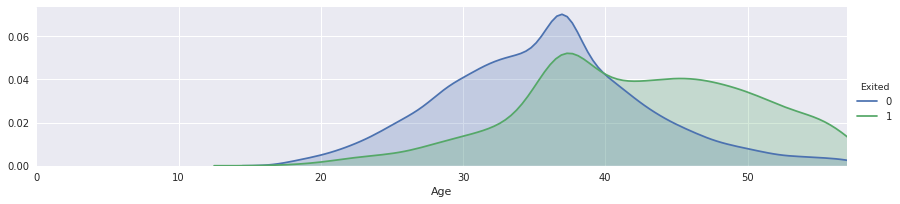

In [17]:
facet = sns.FacetGrid(dataset, hue="Exited",aspect=4)
facet.map(sns.kdeplot,"Age",shade= True)
facet.set(xlim=(0, dataset["Age"].max()))
facet.add_legend()

plt.show()

In [18]:
dataset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619.0,42.0,2,0,1.0,1,1,101349,1,1,0,0,1,0
1,608.0,41.0,1,83808,1.0,0,1,112543,0,0,0,1,1,0
2,502.0,42.0,8,159661,3.0,1,0,113932,1,1,0,0,1,0
3,699.0,39.0,1,0,2.0,0,0,93827,0,1,0,0,1,0
4,850.0,43.0,2,125511,1.0,1,1,79085,0,0,0,1,1,0


## Machine Learning Approach:

In [19]:
X = dataset.iloc[:, dataset.columns != "Exited"]
y = dataset["Exited"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.816

In [22]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.804

In [23]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.786

In [24]:
clf = RandomForestClassifier(n_estimators = 200, random_state=200)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.856

In [25]:
clf = KNeighborsClassifier(n_neighbors=21)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.796

In [26]:
clf = XGBClassifier(max_depth=100, learning_rate=0.03, n_estimators=20)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.839

### Highest accuracy using ML classifiers: 85.6%

In [27]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619.0,42.0,2,0,1.0,1,1,101349,1,0,0,1,0
1,608.0,41.0,1,83808,1.0,0,1,112543,0,0,1,1,0
2,502.0,42.0,8,159661,3.0,1,0,113932,1,0,0,1,0
3,699.0,39.0,1,0,2.0,0,0,93827,1,0,0,1,0
4,850.0,43.0,2,125511,1.0,1,1,79085,0,0,1,1,0


### Feature Scaling

In [28]:
scaler = MinMaxScaler() 

bumpy_features = ["CreditScore", "Age", "Balance",'EstimatedSalary']

df_scaled = pd.DataFrame(data = X)
df_scaled[bumpy_features] = scaler.fit_transform(X[bumpy_features])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:322: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
df_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.505353,0.615385,2,0.000000,1.0,1,1,0.506733,1,0,0,1,0
1,0.481799,0.589744,1,0.334031,1.0,0,1,0.562708,0,0,1,1,0
2,0.254818,0.615385,8,0.636356,3.0,1,0,0.569654,1,0,0,1,0
3,0.676660,0.538462,1,0.000000,2.0,0,0,0.469120,1,0,0,1,0
4,1.000000,0.641026,2,0.500245,1.0,1,1,0.395403,0,0,1,1,0


### Over Sampling

In [30]:
X = df_scaled
sm  = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size= 0.2, random_state=7)

In [33]:
clf = XGBClassifier(max_depth = 12,random_state=7, n_estimators=100, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.8957940991839297
Precision: 0.9147135416666666
Recall: 0.8748443337484434
F1: 0.8943348185868873
Area under precision (AUC) Recall: 0.8633204711711085


In [34]:
# Confusion Matrix

confusion_matrix(y_test, y_pred)

array([[1449,  131],
       [ 201, 1405]])

In [35]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.505353,0.615385,2,0.000000,1.0,1,1,0.506733,1,0,0,1,0
1,0.481799,0.589744,1,0.334031,1.0,0,1,0.562708,0,0,1,1,0
2,0.254818,0.615385,8,0.636356,3.0,1,0,0.569654,1,0,0,1,0
3,0.676660,0.538462,1,0.000000,2.0,0,0,0.469120,1,0,0,1,0
4,1.000000,0.641026,2,0.500245,1.0,1,1,0.395403,0,0,1,1,0


In [38]:
from keras.models import Sequential
from keras.layers import Dense

clf = Sequential()

clf.add(Dense(units = 60, kernel_initializer = "uniform", activation= "relu", input_dim=13))
clf.add(Dense(units = 60, kernel_initializer = "uniform", activation= "relu"))
clf.add(Dense(units = 60, kernel_initializer = "uniform", activation= "relu"))
clf.add(Dense(units = 1, kernel_initializer = "uniform", activation= "sigmoid"))

clf.compile(optimizer="adam", loss = "binary_crossentropy", metrics=["accuracy"])

clf.fit(X_train, y_train, batch_size = 10, epochs=1000)

Epoch 1/1000
12740/12740 [==============================] - 4s 294us/step - loss: 0.5891 - acc: 0.6822
Epoch 2/1000
12740/12740 [==============================] - 3s 267us/step - loss: 0.5417 - acc: 0.7279
Epoch 3/1000
12740/12740 [==============================] - 3s 223us/step - loss: 0.5173 - acc: 0.7490
Epoch 4/1000
12740/12740 [==============================] - 3s 227us/step - loss: 0.4946 - acc: 0.7628
Epoch 5/1000
12740/12740 [==============================] - 3s 199us/step - loss: 0.4824 - acc: 0.7666
Epoch 6/1000
12740/12740 [==============================] - 3s 216us/step - loss: 0.4733 - acc: 0.7715
Epoch 7/1000
12740/12740 [==============================] - 3s 258us/step - loss: 0.4694 - acc: 0.7776
Epoch 8/1000
12740/12740 [==============================] - 3s 253us/step - loss: 0.4638 - acc: 0.7780
Epoch 9/1000
12740/12740 [==============================] - 3s 257us/step - loss: 0.4599 - acc: 0.7812
Epoch 10/1000
12740/12740 [==============================] - 3s 226us/ste

12740/12740 [==============================] - 3s 262us/step - loss: 0.2660 - acc: 0.8823
Epoch 158/1000
12740/12740 [==============================] - 3s 222us/step - loss: 0.2655 - acc: 0.8830
Epoch 159/1000
12740/12740 [==============================] - 3s 223us/step - loss: 0.2668 - acc: 0.8827
Epoch 160/1000
12740/12740 [==============================] - 3s 198us/step - loss: 0.2661 - acc: 0.8819
Epoch 161/1000
12740/12740 [==============================] - 2s 178us/step - loss: 0.2639 - acc: 0.8816
Epoch 162/1000
12740/12740 [==============================] - 3s 246us/step - loss: 0.2630 - acc: 0.8852
Epoch 163/1000
12740/12740 [==============================] - 3s 255us/step - loss: 0.2620 - acc: 0.8840
Epoch 164/1000
12740/12740 [==============================] - 3s 262us/step - loss: 0.2631 - acc: 0.8816
Epoch 165/1000
12740/12740 [==============================] - 3s 225us/step - loss: 0.2644 - acc: 0.8841
Epoch 166/1000
12740/12740 [==============================] - 3s 228us

12740/12740 [==============================] - 3s 236us/step - loss: 0.1876 - acc: 0.9205
Epoch 314/1000
12740/12740 [==============================] - 3s 274us/step - loss: 0.1824 - acc: 0.9211
Epoch 315/1000
12740/12740 [==============================] - 4s 278us/step - loss: 0.1855 - acc: 0.9203
Epoch 316/1000
12740/12740 [==============================] - 3s 263us/step - loss: 0.1779 - acc: 0.9232
Epoch 317/1000
12740/12740 [==============================] - 3s 259us/step - loss: 0.1908 - acc: 0.9197
Epoch 318/1000
12740/12740 [==============================] - 3s 245us/step - loss: 0.1834 - acc: 0.9210
Epoch 319/1000
12740/12740 [==============================] - 3s 233us/step - loss: 0.1796 - acc: 0.9234
Epoch 320/1000
12740/12740 [==============================] - 3s 267us/step - loss: 0.1866 - acc: 0.9221
Epoch 321/1000
12740/12740 [==============================] - 3s 272us/step - loss: 0.1796 - acc: 0.9239
Epoch 322/1000
12740/12740 [==============================] - 3s 255us

12740/12740 [==============================] - 4s 288us/step - loss: 0.1676 - acc: 0.9294
Epoch 392/1000
12740/12740 [==============================] - 4s 297us/step - loss: 0.1591 - acc: 0.9323
Epoch 393/1000
12740/12740 [==============================] - 4s 279us/step - loss: 0.1653 - acc: 0.9296
Epoch 394/1000
12740/12740 [==============================] - 3s 263us/step - loss: 0.1577 - acc: 0.9338
Epoch 395/1000
12740/12740 [==============================] - 3s 233us/step - loss: 0.1610 - acc: 0.9329
Epoch 396/1000
12740/12740 [==============================] - 3s 270us/step - loss: 0.1636 - acc: 0.9318
Epoch 397/1000
12740/12740 [==============================] - 4s 300us/step - loss: 0.1594 - acc: 0.9305
Epoch 398/1000
12740/12740 [==============================] - 4s 299us/step - loss: 0.1577 - acc: 0.9327
Epoch 399/1000
12740/12740 [==============================] - 4s 281us/step - loss: 0.1619 - acc: 0.9319
Epoch 400/1000
12740/12740 [==============================] - 3s 272us

12740/12740 [==============================] - 2s 194us/step - loss: 0.1365 - acc: 0.9481
Epoch 548/1000
12740/12740 [==============================] - 2s 189us/step - loss: 0.1315 - acc: 0.9468
Epoch 549/1000
12740/12740 [==============================] - 2s 176us/step - loss: 0.1324 - acc: 0.9461
Epoch 550/1000
12740/12740 [==============================] - 2s 187us/step - loss: 0.1280 - acc: 0.9483
Epoch 551/1000
12740/12740 [==============================] - 3s 229us/step - loss: 0.1320 - acc: 0.9466
Epoch 552/1000
12740/12740 [==============================] - 3s 215us/step - loss: 0.1310 - acc: 0.9461
Epoch 553/1000
12740/12740 [==============================] - 3s 209us/step - loss: 0.1217 - acc: 0.9514
Epoch 554/1000
12740/12740 [==============================] - 3s 201us/step - loss: 0.1296 - acc: 0.9485
Epoch 555/1000
12740/12740 [==============================] - 3s 207us/step - loss: 0.1293 - acc: 0.9487
Epoch 556/1000
12740/12740 [==============================] - 2s 184us

12740/12740 [==============================] - 3s 237us/step - loss: 0.1068 - acc: 0.9576
Epoch 704/1000
12740/12740 [==============================] - 3s 237us/step - loss: 0.1060 - acc: 0.9576
Epoch 705/1000
12740/12740 [==============================] - 3s 207us/step - loss: 0.1171 - acc: 0.9531
Epoch 706/1000
12740/12740 [==============================] - 3s 208us/step - loss: 0.1129 - acc: 0.9542
Epoch 707/1000
12740/12740 [==============================] - 3s 262us/step - loss: 0.1089 - acc: 0.9574
Epoch 708/1000
12740/12740 [==============================] - 3s 270us/step - loss: 0.1052 - acc: 0.9593
Epoch 709/1000
12740/12740 [==============================] - 3s 260us/step - loss: 0.1216 - acc: 0.9519
Epoch 710/1000
12740/12740 [==============================] - 3s 231us/step - loss: 0.1061 - acc: 0.9567
Epoch 711/1000
12740/12740 [==============================] - 3s 230us/step - loss: 0.1095 - acc: 0.9570
Epoch 712/1000
12740/12740 [==============================] - 3s 207us

12740/12740 [==============================] - 3s 226us/step - loss: 0.0906 - acc: 0.9642
Epoch 860/1000
12740/12740 [==============================] - 3s 208us/step - loss: 0.0976 - acc: 0.9603
Epoch 861/1000
12740/12740 [==============================] - 3s 231us/step - loss: 0.1035 - acc: 0.9611
Epoch 862/1000
12740/12740 [==============================] - 3s 258us/step - loss: 0.1019 - acc: 0.9600
Epoch 863/1000
12740/12740 [==============================] - 3s 258us/step - loss: 0.0957 - acc: 0.9633
Epoch 864/1000
12740/12740 [==============================] - 3s 252us/step - loss: 0.0941 - acc: 0.9635
Epoch 865/1000
12740/12740 [==============================] - 3s 236us/step - loss: 0.0986 - acc: 0.9608
Epoch 866/1000
12740/12740 [==============================] - 3s 212us/step - loss: 0.0925 - acc: 0.9649
Epoch 867/1000
12740/12740 [==============================] - 3s 199us/step - loss: 0.0979 - acc: 0.9604
Epoch 868/1000
12740/12740 [==============================] - 3s 232us

In [39]:
pred = clf.predict(X_test)
#accuracy_score(pred, y_test)
accuracy_score(y_test, pred.round())

0.8449466415568111

## Till Now the best accuracy is: 89.5%